# Library

In [1]:
!pip install torchsummary torchviz pillow

# Data Handling and Processing
import os
import shutil
import numpy as np
import pandas as pd
import cv2
from PIL import Image, ImageOps
from PIL import Image as PILImage  # Untuk manipulasi gambar
from IPython.display import Image as IPImage  # Untuk menampilkan gambar di notebook

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Torchvision for Data Transformations
from torchvision import transforms

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from graphviz import Digraph

# Model Visualization
from torchsummary import summary
from torchviz import make_dot
from IPython.display import Image

# Regular Expressions and Utilities
import re
import math
from collections import defaultdict

# Load Dataset 

In [2]:
class HandwrittenDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = self.data.iloc[:, 0].values  
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_array = self.data.iloc[idx, 1:].values.astype(np.uint8) 
        img_array = img_array.reshape(28, 28)  
        img = PILImage.fromarray(img_array)  
        
        if self.transform:
            img = self.transform(img)  # Terapkan transformasi jika ada
            
        label = self.labels[idx]
        return img, label

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((128, 128)),
    transforms.RandomApply([transforms.RandomInvert()], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

csv_file = '/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv'
full_dataset = HandwrittenDataset(csv_file, transform=train_transform)

labels = full_dataset.labels

train_idx, temp_idx = train_test_split(
    np.arange(len(labels)), 
    test_size=0.2, 
    stratify=labels, 
    random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx, 
    test_size=0.5, 
    stratify=labels[temp_idx], 
    random_state=42
)

train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_subset = Subset(full_dataset, test_idx)

val_subset.dataset.transform = test_transform
test_subset.dataset.transform = test_transform

print(f"Train subset length: {len(train_subset)}")
print(f"Val subset length: {len(val_subset)}")
print(f"Test subset length: {len(test_subset)}")

train_labels = full_dataset.labels[train_idx]
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_labels), 
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class_sample_count = np.array([
    len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)
])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_labels])
samples_weight = torch.from_numpy(samples_weight).double()

sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

class_weights = compute_class_weight('balanced', classes=np.unique(full_dataset.labels), y=full_dataset.labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

Using cuda
Train subset length: 297960
Val subset length: 37245
Test subset length: 37245


# Model

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

class CNN(nn.Module):
    def __init__(self, num_classes=26):
        super(CNN, self).__init__()
        self.in_channels = 64
        
        self.conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)  # 64
        x = self.layer2(x)  # 128
        x = self.layer3(x)  # 256
        x = self.layer4(x)  # 512
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

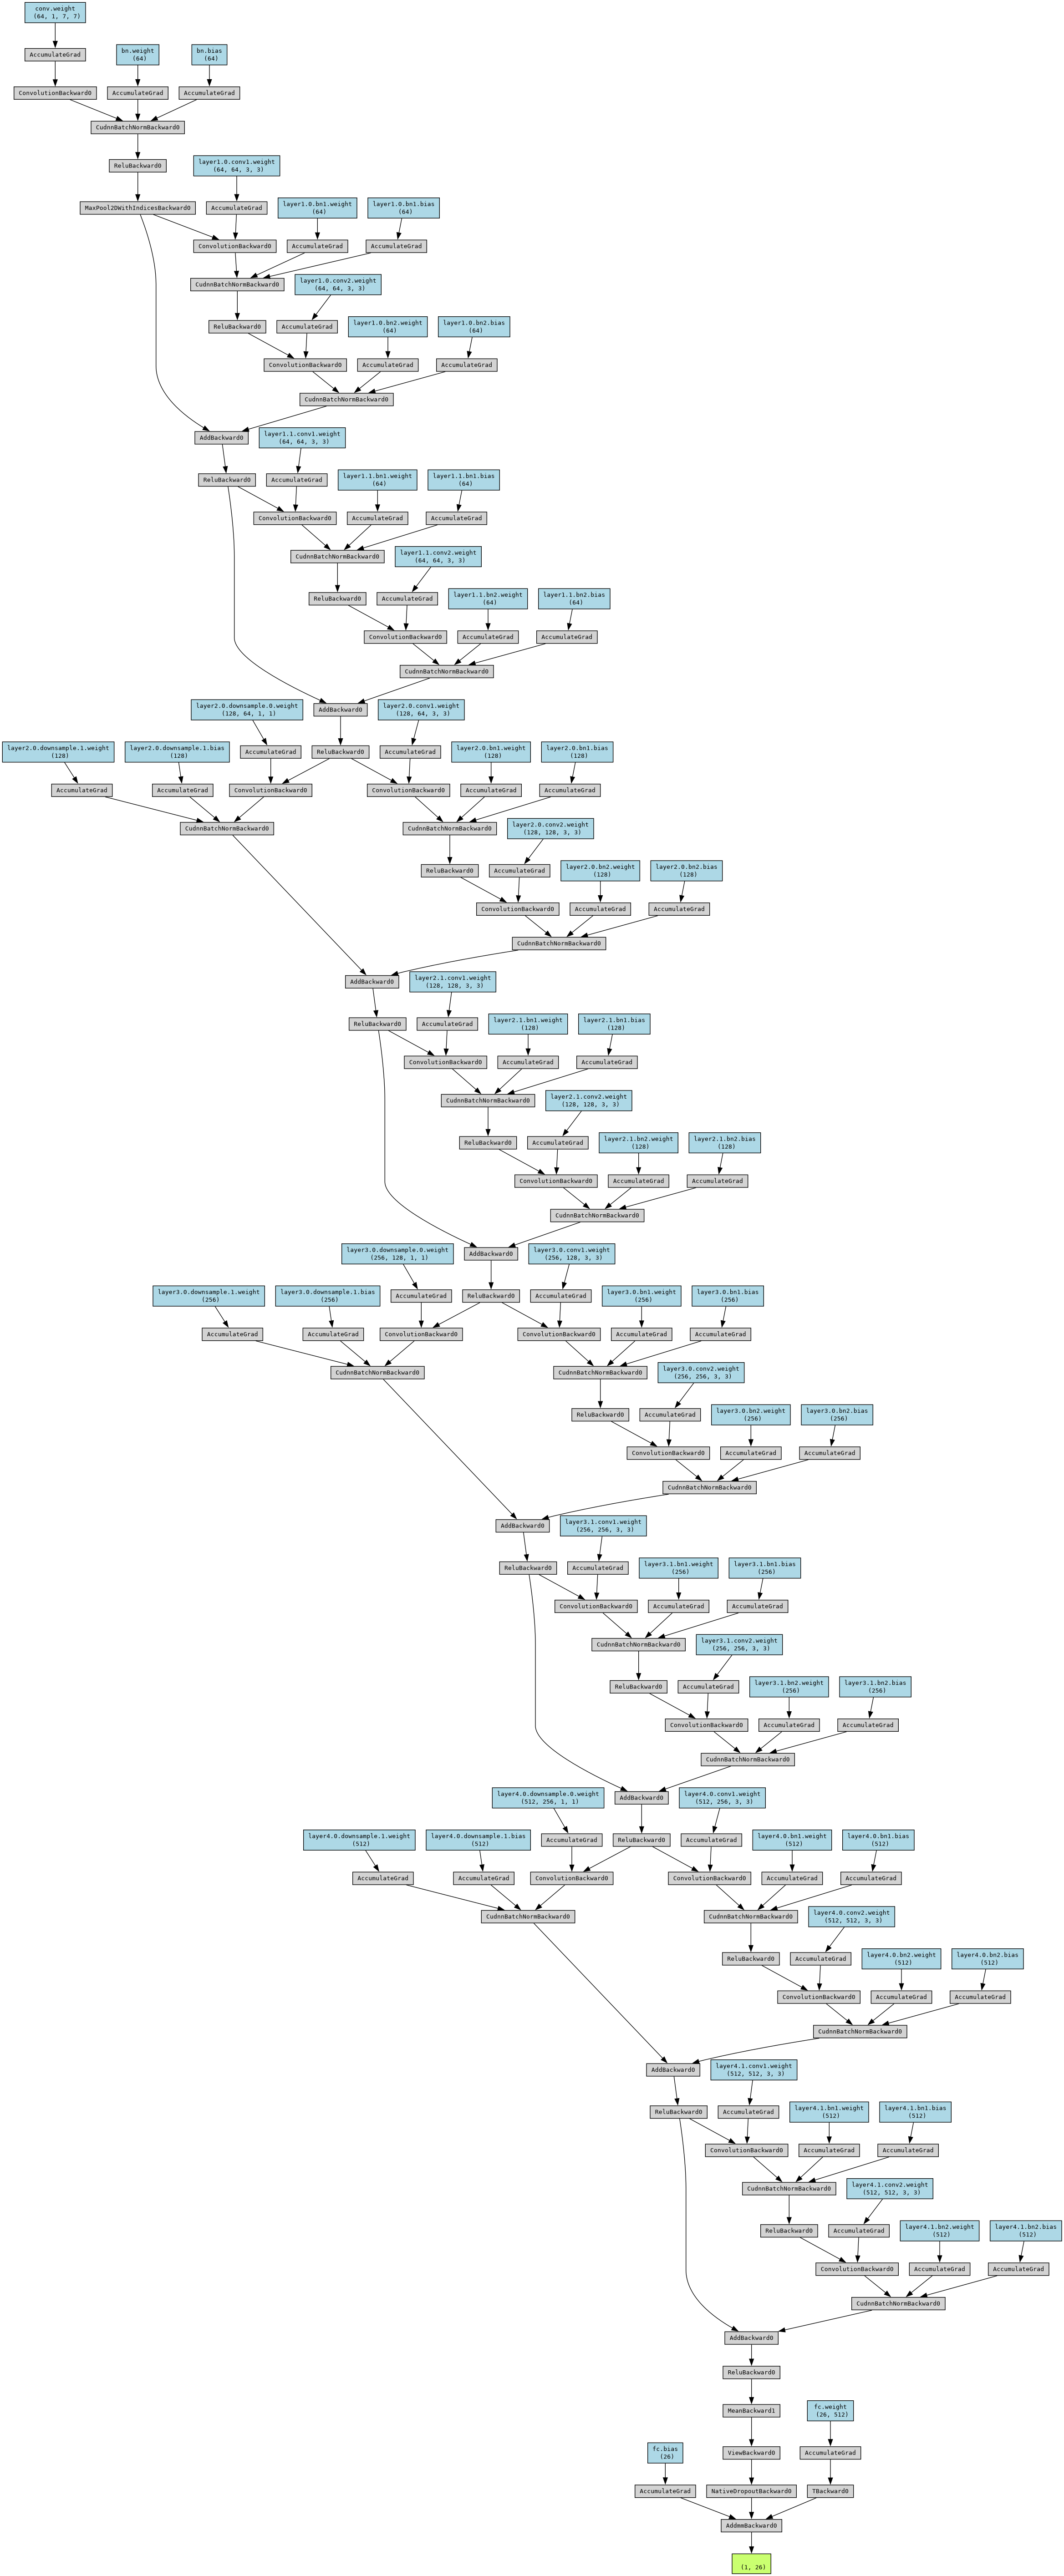

In [5]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

x = torch.randn(1, 1, 128, 128).to(device)  
y = model(x)

make_dot(y, params=dict(model.named_parameters())).render("model_architecture", format="png")
Image(filename="model_architecture.png")

In [6]:
from IPython.display import Image

train_losses = []
val_losses = []
test_losses = []
val_accuracies = []
test_accuracies = []

num_epochs = 10
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    test_loss = 0.0
    correct_test = 0
    total_test = 0
    test_labels = []
    test_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            test_labels.extend(labels.cpu().numpy())
            test_predictions.extend(predicted.cpu().numpy())
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.2f}%, '
          f'Test Loss: {avg_test_loss:.4f}, '
          f'Test Accuracy: {test_accuracy:.2f}%')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

correct = 0
total = 0
test_labels = []
test_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy (Final): {test_accuracy:.2f}%')

Epoch [1/10], Train Loss: 0.0972, Val Loss: 0.0519, Val Accuracy: 97.97%, Test Loss: 0.0502, Test Accuracy: 98.17%
Epoch [2/10], Train Loss: 0.0247, Val Loss: 0.0427, Val Accuracy: 98.12%, Test Loss: 0.0434, Test Accuracy: 98.17%
Epoch [3/10], Train Loss: 0.0155, Val Loss: 0.0285, Val Accuracy: 98.66%, Test Loss: 0.0312, Test Accuracy: 98.73%
Epoch [4/10], Train Loss: 0.0099, Val Loss: 0.0245, Val Accuracy: 99.09%, Test Loss: 0.0280, Test Accuracy: 99.08%
Epoch [5/10], Train Loss: 0.0081, Val Loss: 0.0290, Val Accuracy: 98.67%, Test Loss: 0.0291, Test Accuracy: 98.75%
Epoch [6/10], Train Loss: 0.0057, Val Loss: 0.0213, Val Accuracy: 99.21%, Test Loss: 0.0241, Test Accuracy: 99.21%
Epoch [7/10], Train Loss: 0.0040, Val Loss: 0.0188, Val Accuracy: 99.32%, Test Loss: 0.0201, Test Accuracy: 99.29%
Epoch [8/10], Train Loss: 0.0030, Val Loss: 0.0179, Val Accuracy: 99.32%, Test Loss: 0.0205, Test Accuracy: 99.23%
Epoch [9/10], Train Loss: 0.0034, Val Loss: 0.0194, Val Accuracy: 99.38%, Test L

/tmp/ipykernel_23/542428417.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy (Final): 99.35%


# Evaluation

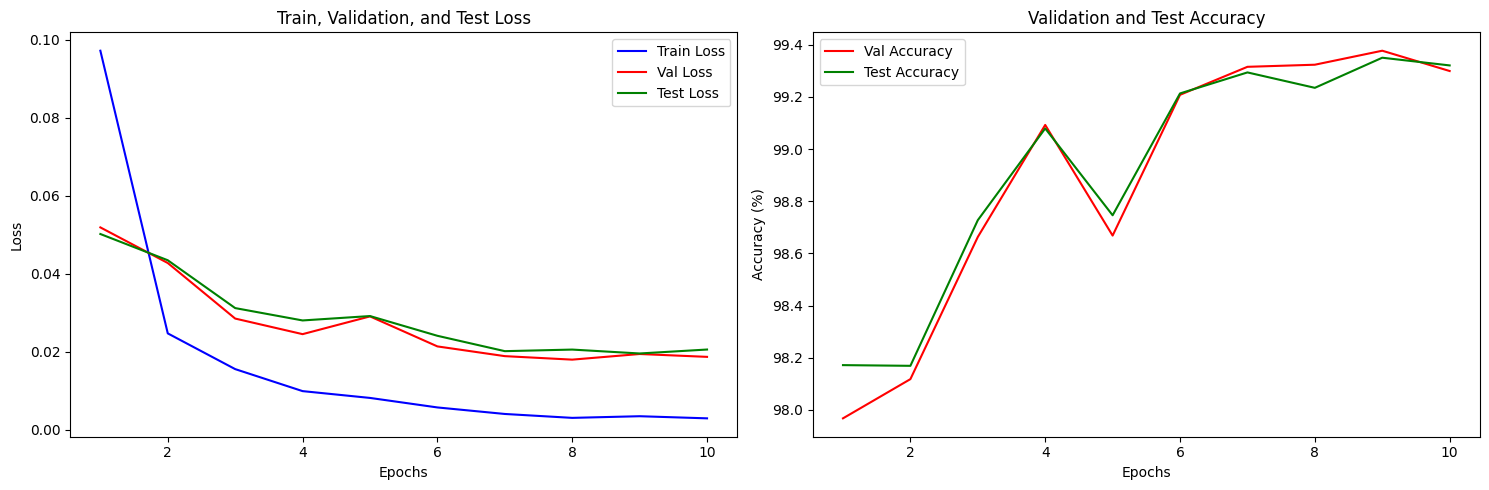

In [7]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='red')
plt.plot(epochs, test_losses, label='Test Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train, Validation, and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='red')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation and Test Accuracy')

plt.tight_layout()
plt.show()

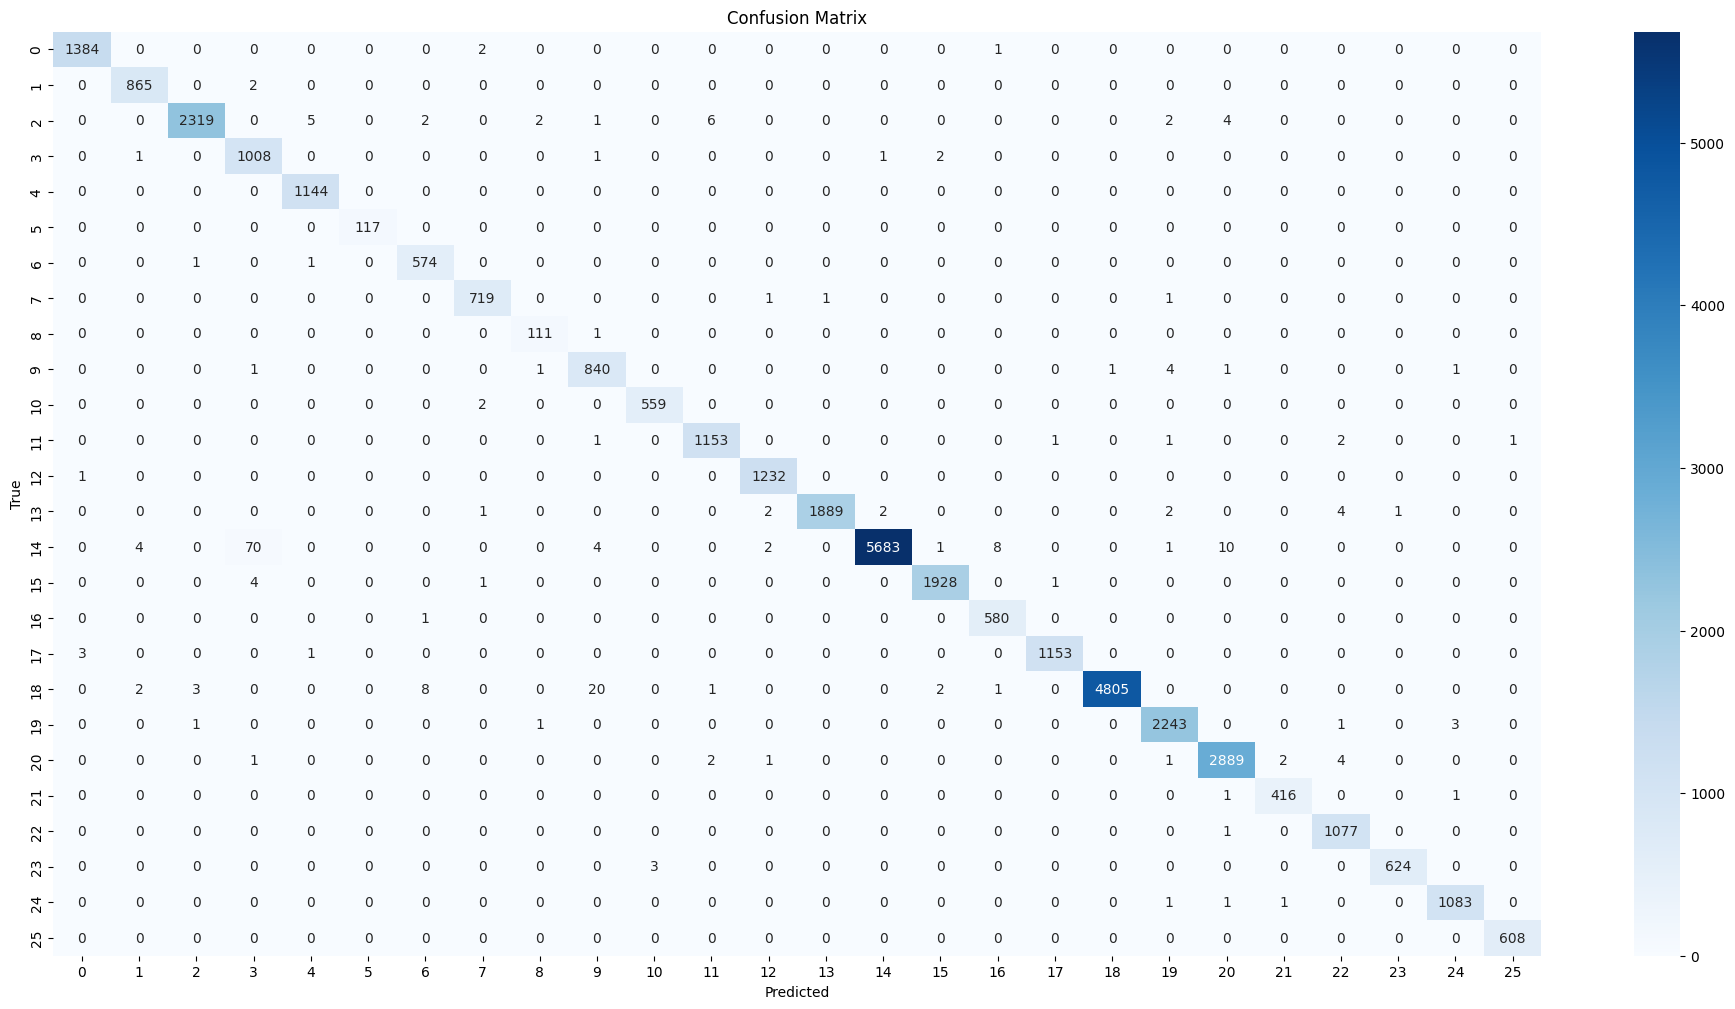

In [8]:
cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(24, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(full_dataset.labels), yticklabels=np.unique(full_dataset.labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save Model

In [9]:
model_save_path = 'model.pth'
torch.save(model.state_dict(), model_save_path)

---

# Input 

In [10]:
def visualize(images, titles, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

In [11]:
def segment_characters(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    kernel = np.ones((2, 2), np.uint8)

    visualize([gray, binary], ["Grayscale", "Result"])

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    bounding_boxes = []
    for i in range(1, num_labels): 
        x, y, w, h, area = stats[i]
        if not (w < 20 and h < 20):
            bounding_boxes.append((x, y, w, h)) 

    line_threshold = 30  
    lines = []
    for box in sorted(bounding_boxes, key=lambda b: b[1]): 
        placed = False
        for line in lines:
            if abs(line[-1][1] - box[1]) < line_threshold:
                line.append(box)
                placed = True
                break
        if not placed:
            lines.append([box])  
    print(f"Number of lines: {len(lines)}")

    for line in lines:
        line.sort(key=lambda b: b[0]) 

    if os.path.exists('chars'):
        shutil.rmtree('chars')

    os.makedirs('chars')

    characters = []
    space_threshold = 30  
    
    for idx, line in enumerate(lines):
        previous_x = None
        word_idx = 0  
        for jdx, (x, y, w, h) in enumerate(line):
            if previous_x is not None and (x - previous_x) > space_threshold:
                word_idx += 1  
            previous_x = x + w 

            char = binary[y:y + h, x:x + w]
            characters.append(char)
            
            cv2.imwrite(f'chars/char_{idx}_{word_idx}_{jdx}.png', 255 - char)

    visualize(characters, [f"Char {i}" for i in range(len(characters))], figsize=(15, 7))

    return characters

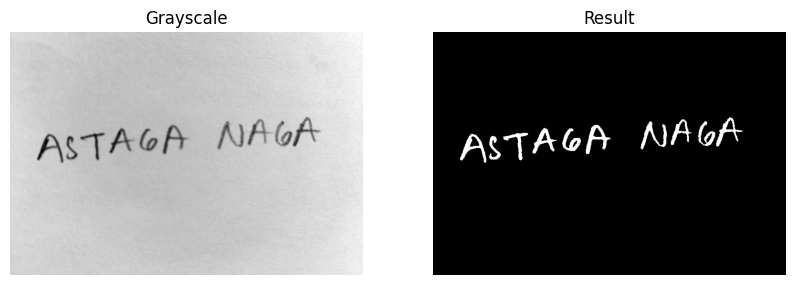

Number of lines: 1


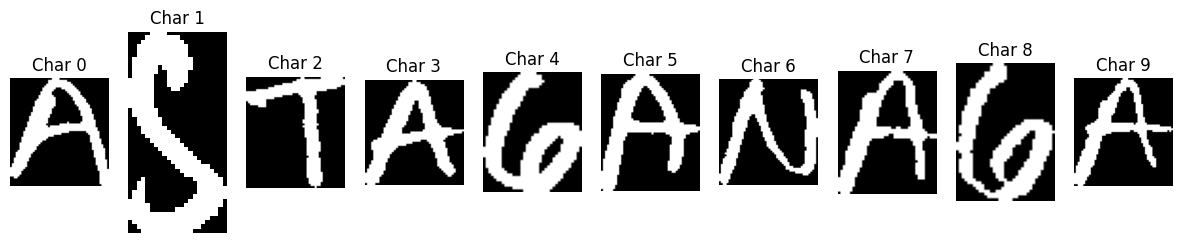

In [12]:
ch = segment_characters("/kaggle/input/input-image/Screenshot 2024-12-12 104859.png")

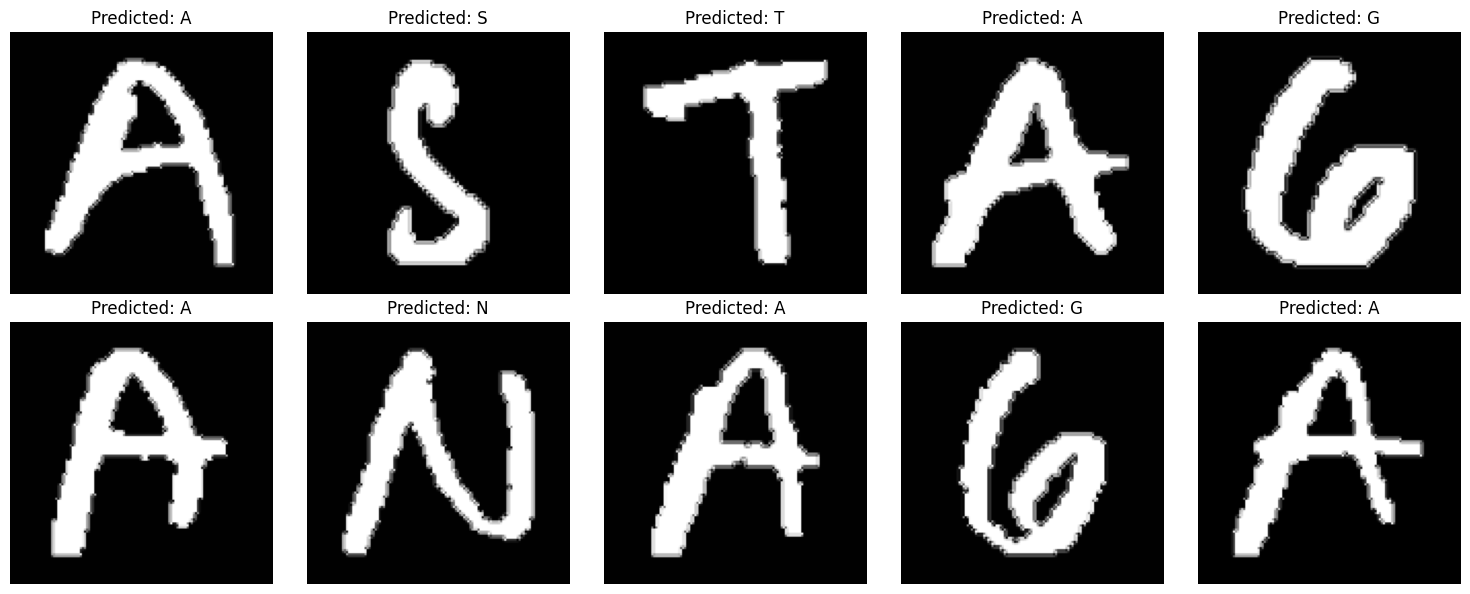

ASTAGA NAGA



In [13]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'([0-9]+)', s)]

class PadToSquareTransform:
    def __init__(self, fill=0):
        self.fill = fill

    def __call__(self, img):
        return pad_to_square(img, fill=self.fill)

def pad_to_square(img, padding_mode='constant', fill='white', pad_ratio=0.15):
    width, height = img.size
    max_side = max(width, height)
    
    padding_left = (max_side - width) // 2
    padding_right = max_side - width - padding_left
    padding_top = (max_side - height) // 2
    padding_bottom = max_side - height - padding_top

    img_padded = ImageOps.expand(
        img, 
        border=(padding_left, padding_top, padding_right, padding_bottom), 
        fill=fill
    )
    
    additional_padding = int(max_side * pad_ratio)
    img_padded = ImageOps.expand(
        img_padded, 
        border=(additional_padding, additional_padding, additional_padding, additional_padding), 
        fill=fill
    )
    
    return img_padded


def predict_image(model, image_path, processed_images_folder="processed_images"):
    image = PILImage.open(image_path).convert('L')  
    image = ImageOps.invert(image)  
    img_array = np.array(image)
    kernel = np.ones((2, 2), np.uint8)
    img_array = cv2.dilate(img_array, kernel, iterations=1)
    image = PILImage.fromarray(img_array)
    
    # Transformasi
    transform = transforms.Compose([
        PadToSquareTransform(fill=0),
        transforms.Grayscale(num_output_channels=1),  
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    processed_image = transform(image).unsqueeze(0).to(device)

    if not os.path.exists(processed_images_folder):
        os.makedirs(processed_images_folder)
    processed_image_pil = transforms.ToPILImage()(processed_image.squeeze(0).cpu())
    processed_image_pil.save(os.path.join(processed_images_folder, os.path.basename(image_path)))

    model.eval()
    with torch.no_grad():
        output = model(processed_image)
        _, predicted = torch.max(output, 1)
        return chr(65 + predicted.item())

def predict_folder(model, folder_path, processed_images_folder="processed_images"):
    results = []
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for filename in image_files:
        image_path = os.path.join(folder_path, filename)
        prediction = predict_image(model, image_path, processed_images_folder)
        results.append((filename, prediction))
    return results

def display_sorted_predictions(predictions, processed_images_folder="processed_images"):
    sorted_predictions = sorted(predictions, key=lambda x: natural_sort_key(x[0]))

    lines = defaultdict(lambda: defaultdict(list))
    
    for filename, pred in sorted_predictions:
        match = re.match(r'char_(\d+)_(\d+)_(\d+)\.png', filename)
        if match:
            line_idx = int(match.group(1))
            word_idx = int(match.group(2))
            char_idx = int(match.group(3))
            lines[line_idx][word_idx].append((char_idx, filename, pred))

    n_images = len(sorted_predictions)
    n_cols = 5
    n_rows = math.ceil(n_images / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()

    idx = 0
    for line_idx in sorted(lines.keys()):
        for word_idx in sorted(lines[line_idx].keys()):
            chars = sorted(lines[line_idx][word_idx], key=lambda x: x[0])
            for char_idx, filename, pred in chars:
                img = PILImage.open(os.path.join(processed_images_folder, filename))  # Menggunakan PILImage.open
                axes[idx].imshow(img, cmap='gray')
                axes[idx].axis('off')
                axes[idx].set_title(f'Predicted: {pred}')
                idx += 1
    for i in range(idx, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    result = ''
    for line_idx in sorted(lines.keys()):
        for word_idx in sorted(lines[line_idx].keys()):
            chars = sorted(lines[line_idx][word_idx], key=lambda x: x[0])
            word_text = ''.join(pred for _, _, pred in chars)
            result += word_text + ' '  # Tambahkan spasi antar kata
        result = result.strip() + '\n'  # Hapus spasi di akhir baris dan tambahkan newline
    print(result)
    
    return result

predictions = predict_folder(model, "chars")
result = display_sorted_predictions(predictions)